In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [3]:
def reset_graph(seed=55):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
gpu_no = '0' # or '1'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_no

# 定义TensorFlow配置
config = tf.ConfigProto()

# 配置GPU内存分配方式，按需增长，很关键
config.gpu_options.allow_growth = True

# 配置可使用的显存比例
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# 在创建session的时候把config作为参数传进去
sess = tf.InteractiveSession(config = config)

在第10章介绍了人工神经网络，并且训练了第一个深度神经网络。但其实它是一个很浅层的DNN，只有两个隐藏层。当需要处理一个复杂问题时，比如要在高分辨率的图片中检测数百种形状的对象，该怎么办呢？可能需要训练一个更深层的DNN，比如说10层，每一层都含有数百个神经元，通过数十万个链接相连。这并不是公园里的一条步道：

* 首先，可能会遇到很诡异的梯度消失问题（或者相关的梯度爆炸问题），它们会影响深度神经网络，从而导致低层训练困难。
* 其次，对于这么庞大的一个网络，训练速度会非常慢。
* 第三，一个有数百万参数的模型会很容易出现过度拟合训练集的风险。

在本章，会回顾每一个问题，并且介绍科学解决方法。会从梯度消失问题开始，探索这类问题目前最流行的解决方案。接着会研究一下相较平坦梯度下降能够在训练大模型时做到明显提速的各种优化器。最后，浏览一下几个流行的针对大型神经网络的正则化技术。

有了这些工具，就能够训练比较深的网络：欢迎来到深度学习！

## 梯度消失/爆炸问题

正如在第10章中讨论的，反向传播算法是从输出层反向作用到输入层，在过程中传播误差梯度。一旦算法根据网络的参数计算出成本函数的梯度，就会根据梯度下降步骤利用这些梯度来修正每一个参数。

不幸的是，梯度经常会随着算法进展到更低层时变得越来越小。导致的结果是，梯度下降在更低层网络连接权值更新方面基本没有改变，而且训练不会收敛到好的结果。这称为`梯度消失`问题。在一些例子中会发生相反的现象：梯度会越来越大，导致很多层的权值疯狂增大，使得算法发散。这就是`梯度爆炸`问题，它经常出现在循环神经网络中（参见第14章）。简单来讲，深度神经网络受制于不稳定梯度；不同层可能会以完全不同的速度学习。

尽管证实这个不幸的表现经历了相当长一段时间（这也是深度神经网络在很长一段时间内几乎被遗弃的原因之一），直到2010年左右在梯度消失问题的研究方面才有了重大的突破。Xavier Glorot和Yoshua Bengio [1] 在论文“Understanding the Difficulty of Training Deep Feedforward Neural Networks”（ http://goo.gl/1rhAef ）中提到几个假设，包括流行的逻辑S激活函数和当时最流行的权重初始化技术的混合，即用均值为0、方差为1的正态分布进行随机初始化。简而言之，利用这种激活函数和初始化方式，他们发现每一层输出方差都比输入方差大很多。在这个网络里，每层都会出现方差增加，直到激活函数最高层饱和。如果逻辑函数的均值变成0.5，这个现象就会变得比较糟（均值为0的双曲正切函数比逻辑函数在深层网络中表现会稍好一些）。

观察逻辑激活函数（见图11-1），会发现当输入变大（正或负），函数在0或1饱和，导数无限靠近0。也就是当反向传播起作用时，实际上并没有梯度通过网络反向作用，同时在反向传播到顶层的过程中几乎没有梯度被稀释，所以基本上没有给低层留下什么。

In [6]:
def logit(z):
    return 1 / (1 + np.exp(-z))

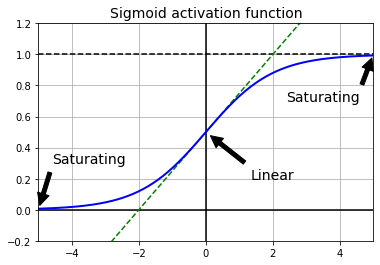

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("sigmoid_saturation_plot")
plt.show()

图11-1：逻辑激活函数饱和

### Xavier初始化和He初始化

在Glorot和Bengio的论文中针对这个问题提出了一个很有效的缓和办法。需要让信号在两个方向都正确流动：当预测的时候要保持正向，在反向传播梯度时保持反方向。我们并不希望信号消亡，同样也不希望它们爆炸或者稀释。为了让信号正确流动，作者提出需要保持每一层的输入和输出的方差一致， [2] 并且需要在反向流动过某一层时，前后的方差也要一致（如果对数学细节感兴趣可以查阅论文）。事实上，这是很难保证的，除非一层有相同数量的输入和输出连接，当然他们也提出了一种很好的折中方案：连接权重必须按照公式11-1进行随机初始化，其中$n _{inputs}$ 和$n_{outputs}$ 是权重被初始化层的输入和输出连接数（也称为扇入和扇出）。这种初始化的方法称为Xavier初始化（以作者的名字命名），有时也称为Glorot初始化。

公式11-1：Xavier初始化（当使用逻辑激活函数时）

均值为0和标准差$\sigma = \sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$的正态分布，或者一个在$-r$和$+r$之间的标准分布，其中$r = \sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$

当输入连接数和输出连接数大体一致时，你可以得到一个简单的等式（比如：$\sigma = \frac{1}{\sqrt {n_{inputs}}}$或者$r = \frac{\sqrt 3}{\sqrt {n_{inputs}}}$）。在第10章 [3] 用过这个简易方法。

利用Xavier初始化方法可以显著提高训练速度，它是众多带领深度学习取得现如今成功的方法之一。近期的一些论文 [4] 为不同的激活函数提供了类似的方法，见表11-1。ReLU激活函数的初始化方法（以及它的变种，包括简称的ELU激活）有时称为He初始化（以作者的姓氏命名）。

表11-1：每种激活函数的初始化参数

|激活函数|均匀分别 -r, r|正态分布|
|:--:|:--:|:--:|
|逻辑函数|$r = \sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$|$\sigma = \sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$|
|双曲正切函数|$r = \sqrt[4]{\frac{6}{n_{inputs}+n_{outputs}}}$|$\sigma = \sqrt[4]{\frac{2}{n_{inputs}+n_{outputs}}}$|
|ReLU（及变种）|$r = \sqrt[\sqrt2]{\frac{6}{n_{inputs}+n_{outputs}}}$|$\sigma = \sqrt[\sqrt2]{\frac{2}{n_{inputs}+n_{outputs}}}$|

`fully_connected()`函数（第10章已介绍）默认用Xavier初始化（用均匀分布）。你可以用下面的方法通过使用`variance_scaling_initializer()`函数将其变成He函数：

In [8]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [9]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


> He初始化只考虑了扇入，没有像Xavier初始化一样取扇入和扇出的平均值。这也是`variance_scaling_initializer()`函数里默认设置的，但是可以通过修改参数`mode="FAN_AVG"`来调整。

### 非饱和激活函数

Glorot和Bengio在2010年的论文中提到一个观点，梯度消失/爆炸问题一部分的原因是选错了激活函数。在那之前很多人一直有这样的假设：如果大自然在生物神经元里都使用了S激活函数，那么这个函数一定是一个绝佳的选择。但结果却表明其他的激活函数在深度神经网络中表现得更好一些，特别是在ReLU激活函数中，出现这种结果最主要的原因是它并不稀释正值（同时也因为计算速度很快）。

然而，ReLU激活函数并不是完美的。它会出现dying ReLU问题：在训练过程中，一些神经元实际上已经死了，即它们只输出0。在一些案例中，可能会发现网络中有一半神经元都死了，特别是当用了一个比较大的训练速度时。在训练过程中，如果神经元的权重更新到神经元输入的总权重是负值时，这个神经元就会开始输出0。当这种情况发生时，除非ReLu函数的梯度为0并且输入为负，否则这个神经元就不会再重新开始工作。

要解决这个问题，可能需要使用ReLU函数的变种，比如leaky ReLU（带泄漏线性整流函数）。这个函数定义为：$LeakyReLU_\alpha(z) = \max(\alpha z, z)$（见图11-2）。超参数$\alpha$表示函数“泄漏”程度：它是函数中$z<0$时的坡度，一般会设置为0.01。这个小坡度可以保证leaky ReLU不会死；它可以进入一个很长的昏迷期，但最后还是有机会醒过来。一篇近期的论文（ https://goo.gl/B1xhKn ） [5] 中对比了几个ReLU激活函数的变种，其中一个结论就是带泄漏变种总是优于严格的ReLU激活函数。实际上，设置$\alpha=0.2$（大泄漏）得到的结果会比$\alpha=0.01$（小泄漏）好。同时，论文中也评估了RReLU（带泄漏随机ReLU），即在训练过程中$\alpha$是在给定区间里的一个随机值，在测试过程中固定在一个平均值。它的表现也很不错，可以作为一个正则（降低了训练集过度拟合的风险）。最后，他们还评估了PReLU（参数线性整流），其中$\alpha$在训练中可以进行学习（不作为超函数，而是在反向传播过程中的参数）。这个函数在大的图片数据集的情况下会比ReLU效果更好，但是在小的数据集时会有训练集过度拟合的风险。

In [10]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

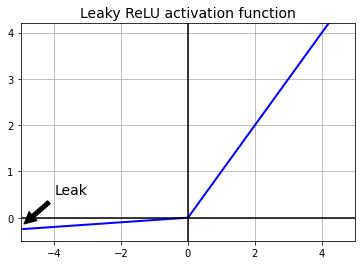

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

#save_fig("leaky_relu_plot")
plt.show()

图11-2：Leaky ReLU（带泄漏线性整流函数）

In [12]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [13]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [14]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [15]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [16]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [17]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [18]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [19]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [22]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [23]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.9028
5 Batch accuracy: 0.92 Validation accuracy: 0.949
10 Batch accuracy: 0.96 Validation accuracy: 0.9644
15 Batch accuracy: 0.98 Validation accuracy: 0.9696
20 Batch accuracy: 1.0 Validation accuracy: 0.9726
25 Batch accuracy: 1.0 Validation accuracy: 0.976
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 1.0 Validation accuracy: 0.978


最后，在Djork-ArnéClevert等人 [6] 2015年发表的一篇论文（ http://goo.gl/Sdl2P7 ）中提出了一个新的激活函数，称为ELU（加速线性单元），在他们的测试中，它的表现优于ReLU的所有变种：训练时间减小，神经网络在测试集的表现也更好。图11-3和公式11-2给出了这个函数的定义。

$$
ELU_\alpha(z) = \begin{cases}
    \alpha(\exp(z) - 1) & (z < 0) \\
    z                   & (z \ge0)
\end{cases} \tag{11-2} \label{11-2}
$$
公式11-2：ELU激活函数

In [24]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

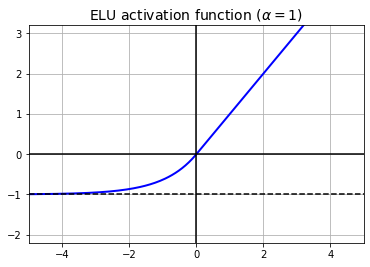

In [25]:
plt.plot(z, elu(z,alpha=1), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("elu_plot")
plt.show()

图11-3：ELU激活函数

ELU激活函数和ReLU函数很像，只是有几个明显的不同：

* 当$z<0$时它的值为负，从而允许单元的平均输出接近0。这样就可以如之前讨论的一样，缓和梯度消失问题。超参数$\alpha$是指当$z$是一个极大的负数时，ELU函数接近的那个值。通常被设置为1，当然如果需要也可以改变它，与其他超参数的操作是一样的。

* 第二，对于$z<0$有一个非零的梯度，这样就可以避免单元消失的问题。

* 第三，这个函数整体很平滑，包括在$z=0$附近，这样就可以提高梯度下降，因为在$z=0$的左右两边都没有抖动。

ELU激活函数的一个主要缺陷是计算速度比ReLU和它的变种慢（因为使用了指数函数），但是在训练过程中，可以通过更快的收敛速度来弥补。然而，测试中，ELU网络时间慢于ReLU网络。

> 那么在深度神经网络的隐藏层到底应该使用哪一种激活函数呢？尽管里程会不一样，通常来说`ELU函数`>`leaky ReLU函数（和它的变种）`>`ReLU函数`>`tanh函数`>`逻辑函数`。如果更关心运行时的性能，那你可以选择`leaky ReLU函数`，而不是ELU函数。如果不想改变别的超参数，就只使用建议$\alpha$的默认值（leaky ReLU函数是0.01，ELU函数是1）。如果有多余的时间和计算能力，可以使用交叉验证去评估别的激活函数，特别是如果网络过度拟合，可以使用RReLU函数，又或者是针对大的训练集使用PReLU函数。

TensorFlow给你提供了一个`elu()`函数来构建神经网络，当调用`fully_connected()`(使用dense，前面讲过)函数时，可以很简单地设置`activation_fn`参数：

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [27]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

TensorFlow没有leaky ReLU函数的预定义函数，但是也可以很简单地定义为：

In [ ]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

### 批量归一化

尽管使用了He初始化加ELU（或者ReLU的任一种变种）可以很明显地在训练初期降低梯度消失/爆炸问题，但还是不能保证在训练过程中不会再出现这些问题。

在一篇发表于2015的论文（ https://goo.gl/gA4GSP ） [7] 中，Sergey Ioffe和Christian Szegedy提出了一个叫作`批量归一化`（BN）的技术，用它来解决梯度消失/爆炸问题，而且每一层的输入分散问题在训练过程中更普遍，前层变量的改变（称为内部协变量转变问题）也是一样。

该技术包括在每一层激活函数之前在模型里加一个操作，`简单零中心化`和`归一化输入`，之后再通过每层的两个新参数（一个为了缩放，另一个为了移动）缩放和移动结果。换句话说，这个操作让模型学会了最佳规模和每层输入的平均值。

为了零中心化和归一化输入，算法需要评估输入的平均值和标准方差。现在对于小批量（因此得名“批量归一化”）是通过评估输入的平均值和标准方差来这么做的。整个操作见公式11-3。

$$
\begin{array}{ll}
1. & \mu_B = \frac{1}{m_B}\sum_{i=1}^{m_B}x^{(i)} \\
2. &\sigma_B^2=\frac{1}{m_B}\sum_{i=1}^{m_B}(x^{(i)}-\mu_B)^2 \\
3. &\hat x^{(i)} = \frac{x^{(i)}-\mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \\
4. &z^{(i)} = \gamma x^{(i)}+\beta
\end{array}
$$

公式11-3：批量归一化算法

- $\mu_B$是经验平均值，评估整个小批量$B$。

- $\sigma_B$是经验标准方差，评估整个小批量。

- $m_B$是小批量的实例数。

- $\hat x^{(i)}$ 零中心化和归一化输入。

- $\gamma$是层缩放参数。

- $\beta$是层移动（偏移）参数。

- $\epsilon$是一个小的数字，为了避免除以0（标准化$10^{-3}$ ）。它被称为平滑项。

- $z^{(i)}$ 是BN操作的输出：它是输入的缩放和移动版。

在测试期间，没有小批量数据来计算经验平均值和标准方差，所以可简单地用整个训练集的平均值和标准方差来代替。在训练过程中可以用变动平均值有效地计算出来。所以，整体来看，4个参数是为每一批量归一化层来学习的：$\gamma$（缩放），$\beta$（偏移），$\mu$（平均值）和$\sigma$（标准方差）。

作者提出的这个技术考虑了他们实验过的所有深度神经网络。梯度消失问题被有效改善，主要原因是他们使用了饱和激活函数（比如tanh）和逻辑激活函数。网络对于权重初始化也没有那么敏感。它们可以使用更高的学习速率，从而有效地加快整个学习过程。值得指出的是，他们提到“在应用到一个先进图片识别的模型时，批量归一化达到了相同的精度，同时还将训练步骤减少为原来的1/14，以显著的成绩击败了原始模型。[…]利用组合的批量归一化网络，我们在ImageNet上目前已经发表过的最佳结果的基础上又做了改进：达到了4.9%top-5的验证错误（4.8%的测试错误），超过了人类评估者的精度。”最终，像一个在持续给予的福利一样，批量归一化同时还可以进行正则化，降低其他正则化技术的需求（比如退出，本章后面会提到）。

但是，批量归一化的确也给模型增加了一些复杂度（尽管因为有第一隐藏层而不用考虑归一化输入数据的需求，但是提供这个需求的却是批量归一化）。另外，还存在一个运行时的代价：神经网络的预测速度变慢，原因是每一层有很多其他需要进行的计算。所以如果需要快速预测，可能需要在进行批量归一化之前先检查一下ELU+He初始化的表现如何。

> 你会发现一开始当梯度下降在每一层搜索最佳缩放和偏移量时，训练速度会非常慢，但是一旦找到一个合适的值，训练速度就会迅速提升。

### 用TensorFlow来实现批量归一化

TensorFlow提供了一个`batch_normalization()`函数来中心化和归一化输入，但是必须自己计算均值和标准方差（在训练中基于一个小批量的数据或者就像刚才讨论的用整个数据集进行测试），然后把它们作为参数传给这个方法，而且必须自己确定缩放和偏移参数（并把它们传给这个方法）。这是可行的，但并不一定是最易行的方式。不过，可以用`batch_norm()`函数，它提供了所有的参数。可以直接调用，或者告诉`fully_connected()`[现在应该是`dense()`]函数去调用它，如以下代码所示：

In [28]:
reset_graph()

#import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


一起看一下上述代码。第一行非常清楚，只要定义了`is_training`(改为`training`)占位符，无所谓是True还是False。它负责告诉`batch_norm()`函数是使用当前小批量的均值和标准方差（训练中），还是使用运行平均值（测试中）。

接着定义了bn_params，它是会传给`batch_norm()`函数的参数集合，当然也包括`training`。算法用到了指数衰减来计算运行平均值，这也是需要衰变参数的原因。给一个新值$v$，运行平均值$\hat v$会通过公式$\hat v \leftarrow \hat v \times decay + v \times (1-decay)$来更新(decay改为momentum)。一个好的衰变值会非常接近1，比如0.9、0.99、0.999（对越大的数据集和越小的批量，需要的9越多）。最后，如果希望`batch_norm()`(实际为`batch_normalization`)函数在训练中（即当`is_training=True`时）一结束批量归一化就更新运行平均值，就需要将`updates_collections`设置成None。如果不设置这些参数，在默认情况下，TensorFlow只将更新运行平均值的操作添加到必须运行的操作集合中。

最后，用第10章中提过的方法，通过调用`fully_connected()`(更改为使用`dense()`)函数来创建层，但是这一次我们在调用激活函数前通过调用`batch_norm()`函数（通过参数nb_params）来进行输入归一化。

> 注意默认情况下，`batch_norm()`只中心化、归一化和对输入进行偏移操作，但是并不缩放（即$\gamma$固定为1）。这样对没有激活函数或者用ReLU激活函数的层是有效果的，但是对于其他的激活函数，你需要设置"scale"，即将bn_params设置为True。

你可能已经注意到，定义前三层是重复的，因为有几个参数是相同的。为了避免一直重复同样的参数，你可以用`arg_scope()`方法构造一个参数范围：第一个参数是一个函数列表，其他参数会自动传给这些函数。最后三行预测代码可以修改成：

In [29]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [30]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [31]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

在这种小例子中，它的表现可能没有以前好，但是如果有10层并且设置了激活函数、初始化、归一化等，代码可读性就会大有改善。

构造阶段剩下的部分和第10章中一致：定义成本函数；构建优化器，让它最小化成本函数；定义评估操作；创建Saver，等等。

实施过程基本一致，只有一处不同。无论何时你运行一个依赖于`batch_norm`层的操作，都需要设置`training`占位符为True或者False：

In [32]:
n_epochs = 40
batch_size = 200

In [33]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if epoch % 10 == 9:
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

0 Validation accuracy: 0.899
1 Validation accuracy: 0.92
2 Validation accuracy: 0.9316
3 Validation accuracy: 0.9384
4 Validation accuracy: 0.9462
5 Validation accuracy: 0.9512
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.9572
8 Validation accuracy: 0.9598
9 Validation accuracy: 0.9614
10 Validation accuracy: 0.9632
11 Validation accuracy: 0.9658
12 Validation accuracy: 0.9662
13 Validation accuracy: 0.967
14 Validation accuracy: 0.9684
15 Validation accuracy: 0.9684
16 Validation accuracy: 0.9692
17 Validation accuracy: 0.9688
18 Validation accuracy: 0.9694
19 Validation accuracy: 0.971
20 Validation accuracy: 0.97
21 Validation accuracy: 0.9716
22 Validation accuracy: 0.9712
23 Validation accuracy: 0.9708
24 Validation accuracy: 0.9718
25 Validation accuracy: 0.9738
26 Validation accuracy: 0.974
27 Validation accuracy: 0.9742
28 Validation accuracy: 0.9736
29 Validation accuracy: 0.9736
30 Validation accuracy: 0.976
31 Validation accuracy: 0.975
32 Validation accuracy: 0.97

就是这样！在这个小例子中只有两层，不像批量归一化有那么显著的影响，但是对于深层网络会有非常明显的效果。

In [34]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)

In [35]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

9 Validation accuracy: 0.9604
19 Validation accuracy: 0.971
29 Validation accuracy: 0.9748
39 Validation accuracy: 0.9762


In [36]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [37]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### 梯度剪裁

一个流行的减轻梯度爆炸问题的技术是在反向传播的过程中简单地裁剪梯度，从而保证不会超过阈值（这个对于循环神经网络非常有效，详见第14章）。这种技术叫作`梯度剪裁`（ http://goo.gl/dRDAaf ） [8] 一般情况下，大家倾向批量归一化，但是仍然有必要了解梯度剪裁以及如何使用它。

在TensorFlow里，优化器的`minimize()`函数同时负责计算和应用梯度，所以必须先调用优化器的`compute_gradients()`方法，然后调用`clip_by_value()`方法创建一个剪裁梯度的操作，最后再调用`apply_gradients()`方法来应用裁剪后的梯度：

In [38]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [39]:
learning_rate = 0.01

In [40]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

一般情况下，需要在每一个训练步骤中都跑一次`training_op`。它会计算梯度，在-1.0和1.0之间剪裁，然后应用。阈值是可以调整的超参数。

In [41]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [42]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 40
batch_size = 200

In [44]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs+1):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if epoch % 10 == 9:
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

9 Validation accuracy: 0.9436
19 Validation accuracy: 0.9614
29 Validation accuracy: 0.9672
39 Validation accuracy: 0.9698


[1] “Understanding the Difficulty of Training Deep Feedforward Neural Networks”，X.Glorot和Y Bengio（2010）。

[2] 有一个类似的例子：如果你把麦克风放大器的旋钮调到非常接近0，人们就不会听到你的声音，同样如果你把它调到非常接近最大值，你的声音也会饱和，大家也听不清你在说什么。现在想象有一连串这样的放大器：它们需要设置好，保证在最后的时候你的声音可以清晰洪亮地传出来。那你的声音就必须保证每经过一个放大器它的输出都和输入有同样的振幅。

[3] 这种简化方法其实很早就已经提出来了——比如，在1998年的《Neural Networks：Tricks of the Trade》一书中就有提过，作者是Genevieve Orr和Klaus-Robert Müller（由Springer出版）。

[4] “Delving Deep into Rectifiers：Surpassing Human-Level Performance on ImageNet Classification”，K.He等人（2015）。

[5] “Empirical Evaluation of Rectified Activations in Convolution Network”，B.Xu等人（2015）。

[6] “Fast and Accurate Deep Network Learning by Exponential Linear Units（ELUs）”，D.Clevert、T.Unterthiner和S.Hochreiter（2015）。

[7] “Batch Normalization：Accelerating Deep Network Training by Reducing Internal Covariate Shift”，S.Ioffe和C.Szegedy（2015）。

[8] “On the difficulty of training recurrent neural networks”，R.Pascanu等人（2013）。

## 重用预训练图层

从头开始训练一个非常庞大的DNN并不明智。大多时候你应该试着去找一个能处理相似问题的已有的神经网络，然后重用它的低层网络，这叫作迁移学习。这不仅能极大地提升训练速度，也很大程度地减少训练数据。

举例来说，假设已经有了一个训练好的DNN用来将图片分成100个类别，包括动物、植物、车辆和各种各样更多的类别。如果你需要训练一个DNN使之能够根据不同的交通工具来分类，因为训练任务和已有的那个十分类似，所以应该试着重用已有的部分网络（见图11-4）。

![图11-4：重用预训练图层](images/VNote/20210112171503853_30764.png)

图11-4：重用预训练图层

> 如果新任务的输入图片和已有任务的输入图片尺寸不一致，就需要添加一个预处理过程来使图片尺寸满足已有任务的输入需求。一般来说，迁移学习只适用于新旧任务的输入有着相似的低层特征的情况。

### 重用TensorFlow模型

如果原有模型是用TensorFlow训练的，你可以轻松地还原该模型并在新任务中接着训练它：

In [45]:
reset_graph()

In [46]:
saver = tf.train.import_meta_graph("./models/my_model_final.ckpt.meta")

In [47]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [48]:
from tensorflow_graph_in_jupyter import show_graph

In [49]:
show_graph(tf.get_default_graph())

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [52]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./models/my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt


In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./models/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt


示例代码中的增加内容：
Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [91]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

In [93]:
with tf.Session() as sess:
    saver.restore(sess, "./models/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt
9 Validation accuracy: 0.9716
19 Validation accuracy: 0.9732
29 Validation accuracy: 0.9732
39 Validation accuracy: 0.9734


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [94]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./models/my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [95]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./models/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./models/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt
9 Validation accuracy: 0.9672
19 Validation accuracy: 0.9718
29 Validation accuracy: 0.9722
39 Validation accuracy: 0.9722


然而，通常我们只想要重用原有模型的一部分（我们马上就会讨论这种状况），一种简单的解决方案就是配置Saver使之在还原原模型时只还原所有参数的一个子集。举例来说，下面的代码就只还原了隐藏层1、隐藏层2和隐藏层3：

In [96]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [98]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./models/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt
9 Validation accuracy: 0.9686
19 Validation accuracy: 0.9726
29 Validation accuracy: 0.972
39 Validation accuracy: 0.973


首先我们建立了新模型，确保它复制了原有模型的隐藏层1到隐藏层3。同时创建了一个节点来初始化所有参数。之后获取到一个用`trainable=true`配置（默认配置）创建的参数列表，并用正则表达式`"hidden[123]"`来做筛选（即：最后得到的就是隐藏层1到隐藏层3的所有可训练参数）。之后创建了一个字典来存放每个参数在原有模型和新模型里的名字映射（通常会保持原名不变）。接下来创建一个Saver用来还原那些参数，创建另一个Saver来存储整个新模型，而不是只有层1到层3。之后开启一个会话，并初始化新模型的所有参数，然后将层1到层3的参数从已有模型中重建。最后，在新任务中训练新模型并存储它。

> 任务越类似，我们就可以重用越多的层（从低层开始）。对于特别相似的任务，可以试着将所有隐藏层都保留，只替换外层。

### 重用其他框架的模型

如果已有模型是用其他框架训练出来的，就需要手动加载所有的权重（例如如果用Theano训练的话，就用Theano代码加载），然后将它们赋给适当的参数。这个过程会变得相当冗长乏味。举例来说，下面的代码展示了如何从其他框架训练出的模型来复制其第一个隐藏层的权重和偏移量。

In [99]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [100]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [101]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [102]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [103]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [104]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### 冻结低层

第一个DNN的低层可能已经学会了检测图像中的低级特征，这对于两个图像分类任务都是有用的，因此可以直接重用这些图层。训练新的DNN时，通常来讲“冻结”权重是一个比较好的方法：如果低层权重被固定，那么高层的权重就比较容易训练（因为不需要学习一个运动的目标）。为了在训练中冻结低层，最简单的办法就是给优化器列出要训练的变量列表，除去低层的变量：

In [105]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [106]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

第三行是获得所有在隐藏层3和隐藏层4及输出层的可训练变量。排除了在隐藏层1和隐藏层2的变量。下一步我们把这个可训练变量的受限列表传给优化器的`minimize()`函数。层1和层2现在被冻结了：它们在训练过程中不会抖动（通常被称为冻结层）。

In [107]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt
9 Validation accuracy: 0.9648
19 Validation accuracy: 0.9678
29 Validation accuracy: 0.9686
39 Validation accuracy: 0.9692


In [108]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [109]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [110]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [111]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt
9 Validation accuracy: 0.9648
19 Validation accuracy: 0.9678
29 Validation accuracy: 0.9686
39 Validation accuracy: 0.9692


### 缓存冻结层

因为冻结层不会变化，所以就有可能将每一个训练实例的最高冻结层的输出缓存起来。由于训练会轮询整个数据集很多次，所以将获得巨大的速度提升，因为只需要在一个训练实例中遍历一次冻结层（而不是每个全数据集一次）。举个例子，可以第一次在低层跑完整个训练集（假设有足够的RAM）：

In [112]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [113]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

然后在训练中，要做的不是构建批量的训练实例，而是批量构建隐藏层2的输出，并且将它们喂给训练操作：

In [114]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./models/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt
9 Validation accuracy: 0.9648
19 Validation accuracy: 0.9678
29 Validation accuracy: 0.9686
39 Validation accuracy: 0.9692


最后一行运行的是之前定义好的训练操作（冻结层1和层2），然后把隐藏层2（对应批量目标）的批量输出传给它。因为把隐藏层2的输出传给TensorFlow，所以它不用尝试去评估它（或者它依赖的其他节点）。

### 调整、丢弃或替换高层

原始模型的输出层经常会被替换，因为对于新的任务基本没有用，甚至没办法提供正确的输出个数。

同样，原始模型的高隐藏层没有低层用处多，因为对于新任务最有效的高级特性可能和原始任务中最有效的那些特性差别很大。需要找到正确的层数来重用。

首先尝试冻结所有的复制层，然后训练模型观察效果。接着尝试解冻一到两个顶部的隐藏层，用反向传播进行调整来观察是否有改善。训练数据越多，越能解冻更多的层。

如果一直不能获得好的效果，而且训练数据很少，那就尝试丢弃最高的一层或多层，然后重新冻结剩下的隐藏层。可以一直迭代直到找到正确的重用层数。如果有很多训练数据，可以尝试替换顶部的隐藏层而不是丢弃它们，甚至可以添加一些隐藏层。

### 模型动物园

在哪里可以找到一个训练好的类似神经网络来完成一个想要解决的任务呢？首选当然是自己已有的模型目录。这是一个很好的方式，可以保存所有的模型，方便你整理，也方便你日后随时调用。另一个选择就是在模型动物园（Model Zoo）里搜索。很多人针对各种任务训练了很多机器学习的模型，并且很慷慨地公开这些预训练的模型。

TensorFlow在 https://github.com/tensorflow/models 上公开了自己的模型动物园。特别需要指出的是，这个模型动物园包含了先进图片识别的网络，比如VGG、Inception和ResNet（见第13章，同时查看models/slim目录），包括代码、预训练模型，以及下载流行图片数据集的工具。

另一个流行的模型动物园是Caffe模型动物园（ https://goo.gl/XI02X3 ）。其中也包括很多计算机视觉模型（比如：LeNet、AlexNet、ZFNet、GoogLeNet、VGGNet和inception），也都在各种数据集（比如ImageNet、Places Database、CIFAR10等）上经过训练。Saumitro Dasgupta写了一个转换器，可以在 https://github.com/ethereon/caffe-tensorflow 找到。

### 无监督的预训练

假设要完成一个没有太多标记训练数据的复杂任务，并且没有找到在近似任务上训练过的模型。不要失去希望！首先，肯定需要努力去收集更多的标记过的训练数据，但是如果这个代价很高或者很难，仍然可以运行无监督的预训练（见图11-5）。也就是说，如果有一堆未标记的训练数据，那可以逐层训练它们，从最低层开始，然后向上，利用一种非监督特性检测算法比如受限玻尔兹曼机（RBM，见附录E）或者自动编码器（见第15章）。每一层都是基于提前训练好的图层（除去被冻结的训练层）的输出进行训练。一旦所有层都用这个方式训练过之后，就可以用监督学习的方式（即反向传播）来微调网络。

这是一个冗长且无趣的过程，但是通常情况下效果都不错；事实上，正是这个Geoffrey Hinton和他的团队在2006使用的技术让神经网络复苏，并且取得了深度学习的成功。直到2010年，无监督的预训练（通常使用RBM）都是深度网络的基准，只有在梯度消失问题得到缓解之后，用反向传播来训练DNN才变得越来越普遍。然而，在面对复杂任务处理、没有相似模型可重用、有极少标记过的训练数据但是却有很多未标记的训练数据的情况下，无监督的预处理（现在通常使用自动编码器而不是RBM）仍然是一个非常不错的选择。 [1]

![图11-5：无监督的预训练](images/VNote/20210113113145872_32450.png)

图11-5：无监督的预训练

### 辅助任务中的预训练

最后一个选择是在辅助任务中训练第一个神经网络，可以轻松获得或者生成标记过的训练数据，然后重用该网络的低层来实现你的实际任务。第一个神经网络的低层会学习可能被第二个神经网络重用的特征检测器。

举个例子，如果想构建一个人脸识别系统，但是只有每个人的几张照片，很明显没办法训练一个好的分类器。收集每个人成百上千张照片根本不可行。但是，可以在网上收集很多随机的人像照片，用它们可以训练第一个神经网络来检测两张不同的照片是否属于相同的人。这个网络将学习优质的人脸特征检测器，然后重用这个网络的低层，这样就可以用很少的训练数据训练出一个优质的人脸分类器。

通常情况下，收集未标记训练示例会廉价很多，但是标记它们却很贵。针对这种情况，常用的技术是将所有示例都标记为“好”，然后通过破坏好的训练示例来生成新的训练实例，并把那些被破坏的实例标记为“坏”。接着就可以训练第一个神经网络来区分好的实例和坏的实例。举个例子，可以下载数百万条句子，标记它们为“好”，然后随机修改每一句中的一个单词，并标记这些修改后的句子为“坏”。如果一个神经网络可以识别出“The dog sleeps”是好，“The dog they”是坏，那么它可能已经学会不少语言了。重用这个网络的低层可能有助于很多语言处理任务。

另一种方法是训练第一个神经网络，让它输出每一个训练实例的得分，然后利用成本函数，确保每一个好的实例的得分都比坏的实例的得分至少高一些。我们称其为`最大边界学习`。

[1] 另一种方式是针对你可以很方便找到大量标记的训练数据运行一个监督任务，然后使用之前提到的迁移学习。举个例子，如果想训练一个模型来识别出图片中你的朋友，可以在网上下载成千上万张脸，然后训练一个分类器来检测两张脸是否一致，之后用这个分类器来对比新图片和每一张你朋友的图片。

## 快速优化器

训练一个很大的深度神经网络可能相当慢。到目前为止，已经了解了四种方法来提高训练速度（并且实现一个更好的解决方案）：在连接权重上应用一个良好的初始化策略，使用一个良好的激活函数，使用批量归一化，以及重用部分预处理网络。另一种明显提高训练速度的方法是使用快速优化器，而不是常规的梯度下降优化器。本节会给出最流行的几种：Momentum（动量优化），NAG（Nesterov梯度加速），AdaGrad，RMSProp，以及Adam优化。

扰乱警报：本节的结论是几乎一直需要使用Adam优化， [1] 所以如果你不关心它的工作原理，那么就只需要简单地用AdamOptimizer替换GradientDescent Optimizer然后跳到下一节就可以了！仅仅是这么简单的一个改变，训练速度就会明显提高好几倍。然而，的确可以调节（加上学习速率）Adam优化的三个超参数；默认值一般表现良好，但是如果需要对它们进行微调，了解每一个值具体是什么还是很有帮助的。Adam优化集合了其他几种优化算法的想法，所以有必要先看看其他算法。

### Momentum优化

想象一个保龄球在光滑表面滚下一个平缓的斜坡：最开始会很慢，但是会迅速恢复动力，直到达到最终速度（假设有一定摩擦力或空气阻力）。这是Momentum优化的一个很简单的想法，由Boris Polyak在1964年提出（ https://goo.gl/FlSE8c ）。 [2] 相比之下，常规梯度下降会沿着斜坡采用常规的小步前进的方式，所以会花比较长的时间才能到达底部。

回顾一下之前的内容，梯度下降是直接从权重$\theta$中减去成本函数$J(\theta)$的梯度（$\nabla_\theta J(\theta)$ ）乘以学习速率$\eta$。公式是：$\theta \rightarrow \theta-\eta \nabla_\theta J(\theta)$ 。它不关心之前的梯度是多少。如果本地梯度很少，它就会走得很慢。

Momentum优化关注以前的梯度是多少：每一个迭代，会给momentum矢量$m$加本地梯度（乘以学习速率$\eta$），同时权重要减去momentum矢量（见公式11-4）。换句话说，梯度被当作加速度来使用，而不是速度。为了模拟某种摩擦机制并防止动量（momentum）增长过大，该算法引入了一个新的超参数$\beta$，简称为动量，其必须设置在0（高摩擦）和1（无摩擦）之间。一个标准动量值为0.9。

$$
\begin{aligned}
1. & m \leftarrow \beta m + \eta \nabla_\theta J(\theta) \\
2. &  \theta \leftarrow \theta - m
\end{aligned}  \tag{11-4} \label{11-4}
$$
公式11-4：Momentum算法

可以很容易地验证当梯度保持一个常量，最终速度（即权重变化的最大值）就等于梯度乘以学习速率$\eta$乘以$1/(1-\beta)$。举个例子，如果$\beta=0.9$，那么最终速度等于10倍梯度乘以学习速率，所以Momentum优化最终会比梯度下降快10倍！这样就使得Momentum优化从平台逃离比梯度下降快得多。值得一提的是，在第4章中看到当输入的尺寸很特别时，成本函数看起来会像一个细长的碗（见图4-7）。梯度下降在陡坡下降得非常快，但是在山谷中下降得很慢。相比较而言，Momentum优化会以越来越快的速度滑向谷底直到到达谷底（最佳）。在不使用批量归一化的深度神经网络中，高层最终常会产生不同尺寸的输入，因此使用Momentum优化会很有帮助，同时还会帮助跨过局部最优。

> 由于有动量，优化器可能会超调一点，然后返回，再超调，来回振荡多次后，最后稳定在最小值。这也是系统中要有一些摩擦的原因之一：它可以帮助摆脱振荡，从而加速收敛。

在TensorFlow中实现Momentum优化非常简单：只需用MomentumOptimizer替换GradientDescentOptimizer，然后等着结果即可。

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

Momentum优化的一个缺点是增加了一个超参数来微调。然而一般情况下，动量值为0.9的表现都比梯度下降好。

### Nesterov梯度加速

Yurii Nesterov在1983年提出了一个Momentum优化的小的变体（ https://goo.gl/V011vD ）， [3] 几乎总快过Vanilla Momentum优化。Nesterov Momentum优化，或者Nesterov梯度加速（NAG），是用来衡量成本函数的梯度的，不是在本地而是动量方向稍向前一点的位置（见公式11-5）。与Vanilla Momentum优化唯一的不同就是用$\theta+\beta m$来测量梯度，而不是$\theta$。

$$
\begin{aligned}
1. & m \leftarrow \beta m + \eta \nabla_\theta J(\theta+\beta m) \\
2. &  \theta \leftarrow \theta - m
\end{aligned}  \tag{11-5} \label{11-5}
$$

公式11-5：Nesterov梯度加速算法

这个小调整有效是因为在通常情况下，动量矢量会指向正确的方向（即最优方向），所以在该方向相对远的地方使用梯度会比在原有地方更准确一些，正如图11-6所示（其中$\nabla_1$表示在起始点$\theta$用成本函数测量的梯度，$\nabla_2$表示在点$\theta+\beta m$的梯度）。正如所见，Nesterov更接近最优值。过一阵之后，这些小的改进叠加在一起，于是NAG就比常规Momentum优化明显增速很多。再者，注意到当动量把权重推过山谷时，$\nabla_1$会跨过山谷并且推向更远，然而$\nabla_2$却往谷底的方向退回了一些。这有助于降低振荡，从而更快收敛。

![图11-6：常规Momentum优化对比Nesterov Momentum优化](images/VNote/20210113160917748_28558.png)

图11-6：常规Momentum优化对比Nesterov Momentum优化

对比Momentum优化，NAG几乎总能提高训练速度。要使用NGA，在创建Momentum Optimizer时只需简单地设置`use_nesterov=True`即可：

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

### AdaGrad

重新考虑一下细长碗的问题：梯度下降开始很快就走下最陡的斜坡，之后慢慢移动到谷底。如果算法可以早点检测到，并且修正方向往全局最优偏移一些就好了。

AdaGrad算法（ http://goo.gl/4Tyd4j ） [4] 通过沿着最陡尺寸缩小梯度向量来实现这一点（见公式11-6）。

$$
\begin{aligned}
1. & s \leftarrow s + \nabla_\theta J(\theta)  \otimes \nabla_\theta J(\theta)\\
2. &  \theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}
\end{aligned}  \tag{11-6} \label{11-6}
$$
公式11-6：AdaGrad算法


第一步将梯度的平方累积到向量$s$中（$\otimes$表示矩阵乘法）。这个向量化表等于给向量$s$中每一个元素$s_i$ 进行$s_i \leftarrow s_i + (\frac{\partial}{\partial\theta_i J(\theta)})^2$运算；换句话说，对于参数$\theta_i$ ，每个$s_i$ 累积成本函数偏导数的平方。如果成本函数沿着第$i$个尺寸陡峭，那么$s_i$会在每一个迭代中越来越大。

第二步与梯度下降基本一致，但是有一个最大的区别：梯度向量按比例$\sqrt{s+\epsilon}$缩小（$\oslash$表示矩阵除法，$\epsilon$是避免除以0的平滑项，通常设置为$10^{-10}$ ）。这个向量化表等于对于所有参数$\theta_i$ 进行$\theta_i \leftarrow \theta_i - \eta \cfrac{\cfrac{\partial}{\partial\theta_i J(\theta)}}{\sqrt{s_i+\epsilon}}$运算（同步）。

简而言之，这个算法衰减了学习速率，但是对于陡度尺寸而言，它比使用较缓斜率的尺寸要快得多。这称为`适应性学习速率`。它有助于将所得到的更新更直接地指向全局最优（见图11-7）。另一个附加的好处是只需对学习速率超参数$\eta$做很少的调整。

![图11-7：AdaGrad对比梯度下降](images/VNote/20210113164840743_28485.png)

图11-7：AdaGrad对比梯度下降

> AdaGrad对于简单的二次问题一般表现都不错，但是在训练神经网络时却经常很早就停滞了。学习速率缩小得很多，在到达全局最优前算法就停止了。所以尽管TensorFlow有AdagradOptimizer，也不要用它来训练深度神经网络（但是，对于类似线性回归这样的简单任务可能是有效的）。

In [ ]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### RMSProp

AdaGrad降速太快而且没办法收敛到全局最优，RMSProp算法 [5] 却通过仅累积最近迭代中的梯度（而非从训练开始的所有梯度）解决了这个问题。它通过在第一步使用指数衰减来实现这个操作（见公式11-7）。

$$
\begin{aligned}
1. & s \leftarrow \beta s + (1-\beta)\nabla_\theta J(\theta)  \otimes \nabla_\theta J(\theta)\\
2. &  \theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}
\end{aligned}  \tag{11-7} \label{11-7}
$$
公式11-7：RMSProp算法

衰减率$\beta$通常设置为0.9。没错，这又是一个新的超参数，但是这个默认值一般表现都比较好，所以基本不需要做任何微调。

正如所期待的，TensorFlow有`RMSPropOptimizer`类：

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

除去非常简单的问题，这个优化器的表现几乎全都优于AdaGrad。同时表现也基本都优于Momentum优化和NAG。事实上，在Adam优化出现之前，它是众多研究者所推荐的优化算法。

### Adam优化

Adam（ https://goo.gl/Un8Axa ）， [6] 代表了自适应力矩估计，集合了Momentum优化和RMSProp的想法：类似Momentum优化，它会跟踪过去梯度的指数衰减平均值，同时也类似RMSProp，它会跟踪过去梯度平方的指数衰减平均值（见公式11-8）。 [7]

$$
\begin{aligned}
1. & m \leftarrow \beta_1 m + (1 - \beta_1) \nabla_\theta J(\theta) \\
2. & s \leftarrow \beta_2 s + (1 - \beta_2) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta) \\
3. & m \leftarrow \frac{m}{1-\beta_1^T} \\
4. & s \leftarrow \frac{s}{1-\beta_2^T} \\
5. & \theta \leftarrow \theta - \eta m \oslash \sqrt{s + \epsilon}
\end{aligned}  \tag{11-8} \label{11-8}
$$
公式11-8：Adam算法

* $T$表示迭代数（从1开始）。

如果只看步骤1、步骤2和步骤5，你会发现Adam同Momentum优化以及RMSProp非常类似。唯一的不同是步骤1计算的是指数衰减的平均值而不是指数衰减的总和，但是除了常数因子以外，它们都是相等的（衰减平均值是$1-\beta_1$ 倍的衰减总和）。步骤3和步骤4是一种技术的细节：因为$m$和$s$初始化都为0，它们会在训练开始时相对0有一点偏移量，所以这两个步骤在训练开始时有助于提高$m$和$s$。

动量衰减超参数$\beta_1$ 通常被初始化为0.9，缩放衰减超参数通常被初始化为0.999。与之前一样，平滑项$\epsilon$通常会设置为一个很小的数字，比如$10^{-8}$ 。这些是TensorFlow的AdamOptimizer类的默认值，可以使用：

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

实际上，因为Adam是一个自适应学习速率算法（与AdaGrad以及RMSProp类似），它需要对学习速率超参数$\eta$进行微调。可以一直使用默认值$\eta=0.001$，这样使得Adam比梯度下降更容易使用。

> 目前讨论过的所有优化技术都依赖于一阶偏导数（Jacobians）。优化文献包含基于二阶偏导数（Hessians）的算法。不幸的是，这些算法都非常难应用到深度神经网络，原因是每层输出都有$n^2$ Hessians（其中$n$是参数个数），而不是每次只有$n$ Jacobians。因为DNN通常有数万个参数，所以二阶优化算法一般不会在内存里适用，而且即使运行，计算Hessians也会非常慢。

### 训练稀疏模型

所有提到的优化算法都是制作密集模型，意味着大部分参数都是非零的。如果需要在运行时有一个超速模型，或者如果你需要它占用更少的内存，最终可能需要一个稀疏模型。

实现这个目的的一个小方法是像往常一样训练模型，然后摆脱掉小的权重（将其设置为0）。

另一种方法是在训练中应用强1正则化，因为它可以促使优化器尽可能地将权重归零（如第4章讨论的Lasso回归）。

然而，在某些例子中这些技术可能会无效。最后一个方法是应用对偶平均，通常称为FTRL（Fllow The Regularized Leader），这是Yurii Nesterov（ https://goo.gl/xSQD4C ） [8] 提出的一个技术。当使用$\ell_1$正则化时，这种技术会导出一个非常稀疏的模型。TensorFlow在FTRLOptimizer类中实现了一个名为FTRL-Proximal（ https://goo.gl/bxme2B ） [9] 的FTRL变体。

### 学习速率调度

要找到一个良好的学习速率会比较麻烦。如果你把它设置得太高，训练可能会产生分歧（如第4章讨论的）。如果设置得太低，训练可能需要花很长的时间才能收敛到最优解。如果设置得相对高一些，可能最开始运行得很快，但是最后一直在最优解附近摆动不停下来（除非你使用适应性学习速率优化算法，比如AdaGrad、RMSProp或者Adam，但即使这样也需要时间来稳定）。如果计算机预算有限，你可能必须在训练正确收敛之前停下来，从而生成次优解（见图11-8）。


![图11-8：不同学习速率的学习曲线](images/VNote/20210113191216819_2290.png)
图11-8：不同学习速率的学习曲线

可能会通过使用各种学习速率，对比学习曲线在几个数据集内多次训练网络，从而得到一个非常良好的学习速率。理想的学习速率学习速度非常快，并且会收敛到良好的解决方案。

然而相比一个固定的学习速率，可以做得更好：如果以一个高学习速率开始，然后一旦它停止快速过程就降低速率，那么会获得一个比最优固定学习速率更快速的方案。有很多不同的策略在训练过程中监督学习速率。这些策略称为学习计划（我们在第4章简单介绍过这个概念），最常用的有：

* 预定分段常数学习速率

举个例子，最开始设置学习速率$\eta_0 =0.1$，在50个数据集之后设置$\eta_0 =0.01$。尽管这个方法效果不错，但是需要搞清楚正确的学习速率和何时使用。

* 性能调度

每N个步骤进行测量来验证错误（比如早起停止），然后当错误停止出现时，将学习速率降低到$1/\lambda$。

* 指数调度

将学习速率设置为迭代数t的函数：$\eta(t)=\eta_0 10^{-t/r}$ 。这个效果很好，但是需要微调$\eta_0$ 和$r$。学习速率每$r$步下降10。

* 功率调度

设置学习速率为$\eta(t)=\eta_0(1+t/r)^{-c}$。超参数$c$通常设置为1。这个与指数调度类似，但是学习速率降低得非常慢。

Andrew Senior等人在2013年的一篇论文（ http://goo.gl/Hu6Zyq ） [10] 中对比了运用Momentum优化训练深度神经网络进行语音识别的一些最受欢迎的学习计划的表现。作者总结，在这样的设置下，性能调度和指数调度表现都很好，但是他们更推荐指数调度，因为它更容易实现，容易微调，而且收敛到最优解的速度稍快一些。

用TensorFlow实现学习计划非常直接：

In [115]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [116]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

设置完超参数值后，创建一个不可训练变量`global_step`（初始化为0）来跟踪当前训练的迭代数。然后用TensorFlow的`exponential_decay()`函数定义一个指数衰减学习速率（其中$\eta_0 =0.1$，$r=10000$）。接着，构建一个使用该衰减学习速率的优化器（本例使用了`MomentumOptimizer`）。最后，通过调用优化器的`minimize()`方法构建训练操作；因为给它传入了`global_step`变量，所以它会自增。

因为AdaGrad、RMSProp和Adam优化在训练中自动降低了学习速率，所以不需要额外加入学习计划。对于其他的优化算法，使用指数衰减或性能调度可以很有效地提高收敛速度。

In [117]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [118]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

9 Validation accuracy: 0.9836
19 Validation accuracy: 0.9836
29 Validation accuracy: 0.9838
39 Validation accuracy: 0.9838


[1] 至少就现在来讲：研究进展很快，特别是针对优化领域。请确保在每一个TensorFlow新版本发布的时候查看一下最新和最好的优化器。

[2] “Some methods of speeding up the convergence of iteration methods”，B.Polyak（1964）。

[3] “A Method for Unconstrained Convex Minimization Problem with the Rate of Convergence O（1/k2）”，Yurii Nesterov（1983）。

[4] “Adaptive Subgradient Methods for Online Learning and Stochastic Optimization”，J.Duchi等人（2011）。

[5] 这个算法是Tijmen Tieleman和Geoffrey Hinton在2012年提出的，并且由Geoffrey Hinton在他的针对神经网络的Coursera课程上发表（幻灯片地址：http://goo.gl/RsQeis ；视频地址： https://goo.gl/XUbIyJ ）。 有趣的是，因为作者并没有在任何论文中提到这个算法，所以研究者经常在他们的论文中以“讲座6的第29张幻灯片”的方式进行引用。

[6] “Adam：A Method for Stochastic Optimization”，D.Kingma和J.Ba（2015）。

[7] 这些是梯度均值和（非中心）方差的估值。均值被称为第一力矩，方差被称为第二力矩，从而有了算法的名字。

[8] “Primal-Dual Subgradient Methods for Convex Problems”，Yurii Nesterov（2005）。

[9] “Ad Click Prediction：a View from the Trenches”，H.McMahan等人（2013）。

[10] “An Empirical Study of Learning Rates in Deep Neural Networks for Speech Recognition”，A.Senior等人（2013）。

## 通过正则化避免过度拟合

用四个参数我可以适应一头大象，用五个参数我可以让它摆动躯干。

——John von Neumann，Enrico Fermi在Nature 427中引用

深度神经网络通常有数万个参数，有时甚至过亿。因为有大量参数，网络具有相当的自由度，可以使用各种恶意复杂的数据集。但是这种极大的灵活性也意味着它容易过度拟合训练集。

拥有数亿的参数可以适应整个动物园。本节中会给出集中神经网络中最受欢迎的正则化技术，以及用TensorFlow怎样实现：提前停止，$\ell_1$和$\ell_2$正则化、dropout、最大范数正则化和数据扩充。

### 提前停止

要避免过度拟合训练集，有一个解决方案是提前停止（在第4章介绍过）：当验证集的性能开始下降时停止训练。

用TensorFlow实现提前停止的一种方法是定期对验证集进行模型评估（比如：每50步），同时如果表现好于前一个“优胜者”快照就将此“优胜者”快照保存起来。在保存最后一张“优胜者”快照的时候计算步数，当步数达到某些限制（比如：2000步）时停止训练。然后恢复最后一张“优胜者”快照。

尽管在练习中提前停止表现得很好，但通常你还是可以通过结合其他正则化技术来获得更高的性能。

### $\ell_1$和$\ell_2$正则化

与第4章中简单的线性模型一样，可以使用$\ell_1$和$\ell_2$正则化来约束一个神经网络的连接权重（但通常不是其偏差）。

用TensorFlow实现的一个方式是简单地将适当的正则项加在成本函数中。举个例子，假设只有一个隐藏层，权重为weight1，一个输出层，权重为weight2，然后可以这样使用$\ell_1$正则化：

In [119]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [120]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

然而，如果层数多，这个方法就不是很有效。幸运的是，TensorFlow提供了一个更好的方案。许多构建变量的函数（比如`get_variable()`和`fully_connected()`）在构建每一个变量（比如`weights_regularizer`）时可以接受一个参数`*_regularizer`。可以传递任何把权重作为参数并且返回相应的正则化损失的函数。函数`l1_regularizer()`、`l2_regularizer()`和`l1_l2_regularizer()`返回这些函数。下面的代码把它们放在一起：

In [121]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [122]:
n_epochs = 40
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

9 Validation accuracy: 0.9064
19 Validation accuracy: 0.9062
29 Validation accuracy: 0.9018
39 Validation accuracy: 0.9054


In [127]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [128]:
scale = 0.001

In [130]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    #kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
    kernel_regularizer = tf.keras.regularizers.l1(scale))


with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

这个代码构建了一个有两个隐藏层和一个输出层的神经网络，同时也在图中构建了节点来计算对应每一层权重的 正则化损失。TensorFlow自动将这些节点加到一个包含所有正则化损失的特殊连接中。只需要将这些正则化损失加到你整体的损失中即可，类似这样：

In [131]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

> 不要忘记将正则化损失加到整体损失中，不然就会被直接忽略掉。

In [132]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [133]:
n_epochs = 40
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

9 Validation accuracy: 0.9214
19 Validation accuracy: 0.9206
29 Validation accuracy: 0.918
39 Validation accuracy: 0.9222


### Dropout

最受欢迎的深度神经网络正则化技术无疑是dropout。它是由G.E.Hinton在2012年提出的（ https://goo.gl/PMjVnG ） [1] ，Nitish Srivastava等人在之后的一篇论文（ http://goo.gl/DNKZo1 ） [2] 中进行了更细致的解释，并且证明有很高的成功率：即使是最先进的神经网络在加了dropout之后也能提高1%～2%的正确性。这看上去可能不是很多，但是当一个模型已经有95%的正确性，提高2%就意味着降低了将近40%的错误率（从5%的误差到差不多3%）。

这是一个很简单的算法：每一个训练步骤，每一个神经元（包括输入神经元，不包括输出神经元）都有一个会被暂时“丢弃”的可能性$p$，意思是在这次训练步骤中它会被完全忽略，但是到下一步的时候就会被激活（见图11-9）。超参数$p$被称为`丢弃率`，通常设置为50%。在训练之后，神经元不会再被丢弃。原理就是这样。

![图11-9：dropout正则化](images/VNote/20210114151910505_22674.png)

图11-9：dropout正则化

最开始这种相当暴力的方法可以起作用也是非常令人震惊的。如果员工每天早上通过扔硬币来决定去不去上班，这样的公司会越来越好吗？好吧，谁知道呢，说不定会呢！公司很明显是要去适应它的组织，而不是依赖某一个人去填充咖啡机或者去做其他关键的任务，所以这些专业知识必须分散到好几个人身上。员工需要学习和许多同事一些协作，而不仅是其中几个人。公司的适应性会越来越好。如果有一个人离开，也不会有太大的影响。现在还不清楚这个想法对于公司是不是真正奏效，但是对于神经网络的确是有用的。训练有dropout的神经元不能和周围的神经元共适应；它们必须让自己尽可能有用。它们也不能过分依赖几个输入神经元；它们必须关注每一个输入神经元。它们最后会变得对于输入的轻微变化不那么敏感。最终，会获得一个更好地泛化了的健壮的网络。

再者，理解dropout的强大是因为注意到在每一个训练步骤都会创建一个独立的神经网络。因为每一个神经元都可能出现或不出现，所以就会有总共$2^N$ 个可能的网络（其中N是可丢弃神经元的个数）。这是一个很大的数字，几乎不可能对一个神经网络采样两次。一旦已经运行了10000个训练步骤，那实际上就已经训练了10000个不同的神经网络（每一个网络都有一个训练实例）。这些神经网络很明显不是独立的，因为它们共享很多它们的权重，但是它们还是不同的。所得到的神经网络可以看作是这些较小的神经网络的平均集合。

这里提到一个很小但是很重要的技术细节。假设p=50，在测试期间，一个神经元将会被连接到训练期间输入神经元（平均）的两倍。为了弥补这个情况，需要在训练之后给每一个神经元的输入连接权重乘以0.5。如果不这样做，每一个神经元就会得到一个总输入信号，大概是之前训练网络的两倍，而且性能不会表现得特别好。更通俗来讲，需要在训练结束后给每一个输入连接权重乘以保持可能性（1-p）。或者，可以在训练过程中给每一个神经元的输出除以保持可能性（这些可选方案不完全一致，但是它们的效果都一样好）。

要用TensorFlow实现dropout，可以直接在输入层和每一个隐藏层的输出调用`dropout()`函数。在训练中，这个函数会随机丢弃一些项（把它们设置为0），并且给剩下的项除以保持可能性。在训练结束后，这个函数什么也不做。下面是一个针对三层神经网络应用dropout正则化的例子：

In [142]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [143]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)
#X_drop = tf.keras.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [144]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [145]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

9 Validation accuracy: 0.9668
19 Validation accuracy: 0.9742
29 Validation accuracy: 0.975
39 Validation accuracy: 0.9768


> 想在tensorflow.contrib.layers调用`dropout()`，而不是tensorflow.nn。在不训练的时候，对想调用的第一个关掉（no-op），但是第二个不关。

当然，与之前批量归一化类似，需要在训练时设置`training`为True，在测试时设置`training`为False。

如果发现模型过度拟合，可以提高dropout速率（即降低`keep_prob`超参数）。相反，如果模型不拟合训练集，需要降低dropout速率（即提高`keep_prob`超参数）。同样针对大层可以帮助提高dropout速率，针对小层可以降低。

dropout确实收敛变慢，但是如果微调合适，它通常都会得到一个更好的模型。所以这个结果是值得付出多一些时间和代价的。

> Dropconnect是dropout的一个变体，它随机丢弃掉独立连接，而不是整个神经元。通常情况下，dropout表现得更好。

### 最大范数正则化

另一种神经网络比较流行的正则化技术叫作`最大范数正则化`：对每一个神经元，包含一个传入连接权重w满足$||w||_2 \leq r$，其中$r$是最大范数超参数，$||\cdot||_2$ 是$\ell_2$范数。

通常这样来满足这个约束，在每一次训练步骤后计算$||w||_2$ ，同时如果需要会剪裁 。

降低$r$会增加正则化数目，同时帮助减少过度拟合。最大范数正则化可以同时帮助缓解梯度消失/爆炸问题（如果不使用批量归一化）。

TensorFlow没有提供现成的最大范数正则化器，但是实现起来也不难。下面的代码构建了一个节点clip_weights，该节点会沿着第二个轴削减weights变量，从而使每一个行向量的最大范数为1.0：

In [146]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [147]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

可以按照下面的方法在每一个训练步骤之后进行操作：

In [148]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [149]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [150]:
n_epochs = 40
batch_size = 50

In [152]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./models/my_model_final.ckpt")               # not shown

9 Validation accuracy: 0.9826
19 Validation accuracy: 0.984
29 Validation accuracy: 0.9852
39 Validation accuracy: 0.9852


threshold = 1.0

clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)

clip_weights = tf.assign(weights, clipped_weights)


with tf.Session() as sess:

    [...]

    for epoch in range(n_epochs):

        [...]

        for X_batch, y_batch in zip(X_batches, y_batches):

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

            clip_weights.eval()
如果你不知道如何获得每一层的weights变量。你可以像下面这样调用一个可变范围：

hidden1 = fully_connected(X, n_hidden1, scope="hidden1")



with tf.variable_scope("hidden1", reuse=True):

    weights1 = tf.get_variable("weights")
同样，你也可以调用根变量范围：

hidden1 = fully_connected(X, n_hidden1, scope="hidden1")

hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")

[...]



with tf.variable_scope("", default_name="", reuse=True):  # root scope

    weights1 = tf.get_variable("hidden1/weights")

    weights2 = tf.get_variable("hidden2/weights")
如果你不知道某个变量的名字，可以调用TensorBoard去查询或者调用global_variables（）函数打印出所有的变量名：

for variable in tf.global_variables():

    print(variable.name)
尽管之前的方法效果不错，但是还是有点烦琐。一个简洁的方法是构建一个`max_norm_regularizer()`函数，像之前的`l1_regularizer()`函数一样使用：

In [155]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

这个函数返回一个参数化`max_norm()`函数，可以像其他正则化器一样使用它：

In [156]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [157]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

最大范数正则化不需要将正则化损失项加入整体损失函数，所以`max_norm()`方法返回None。但是仍然需要在每一个训练步骤之后返回`clip_weights`操作，这样才可以获取它的句柄。这就是为什么`max_norm()`函数要添加`clip_weights`节点到最大范数剪裁操作集合里。需要调用这些剪裁操作并在每一个训练步骤之后返回它们：

In [158]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [159]:
n_epochs = 40
batch_size = 50

In [162]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        if (epoch % 10 == 9):
            print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./models/my_model_final.ckpt")             # not shown

9 Validation accuracy: 0.9804
19 Validation accuracy: 0.9848
29 Validation accuracy: 0.9838
39 Validation accuracy: 0.9844


代码整洁多了，是吧？

### 数据扩充

最后一个正则化技术是数据扩充，包括从已有实例构建新的训练实例，人为提高训练集大小。因为会减少过度拟合，所以它是一种正则化技术。棘手的是构建一个切实可用的训练实例；理想情况下，人是没办法区分哪个实例建好了，哪个没有建好。而且，简单地增加白噪声也没有用；进行的修改应该是可学习的（白噪声不可学习）。

举个例子，如果你的模型要区分蘑菇的照片，你可简单地移动、旋转和改变每张在训练集中的照片的大小，同时把这些改变后的照片添加进训练集中（见图11-10）。这就迫使模型要兼容照片中蘑菇的位置、方向和大小。如果你希望模型对光的敏感度也增加，那你可以类似地生成许多具有各种对比度的照片。假设蘑菇是对称的，你也可以水平翻转照片。通过混合各种变换，你可以很快地增加你的训练集。

![图11-10：用现有实例来生成新的训练实例](images/VNote/20210114163158865_11629.png)

图11-10：用现有实例来生成新的训练实例

一般偏向在训练过程中快速生成训练实例，而不是浪费存储空间和网络带宽。TensorFlow提供了多种图片处理操作，比如转置（偏移）、旋转、调整大小、翻转和裁剪，同时还有调整亮度、对比度、饱和度和色调（详见API文档）。这样就可以轻松地实现图像数据集的数据扩充。

> 另外一种训练深度神经网络的有效技术是添加跳过连接（跳过连接就是把层输入加到高层的输出上）。会在第13章讨论到深度残留网络时再展开讨论。

[1] “Improving neural networks by preventing co-adaptation of feature detectors”，G.Hinton等人（2012）。

[2] “Dropout：A Simple Way to Prevent Neural Networks from Overfitting”，N.Srivastava等人（2014）。

## 实用指南

在这一章里，介绍了很多技术，可能会搞不清到底应该用哪一个。表11-2中的配置在大多数情况下都是有用的。

|                        |                     |
| ---------------------- | ------------------- |
| Initialization         | He initialization   |
| Activation Function    | ELU                 |
| Normalization          | Batch Normalization |
| Regularization         | dropout             |
| Optimizer              | Adam                |
| Learning rate schedule | None                |

表11-2：默认DNN配置

当然，如果能够找到解决类似问题的方法，应该尝试重用部分预训练的神经网络。

这个默认配置可能需要调整：

- 如果找不到良好的学习速率（之前收敛太慢，所以你想提高训练速率，现在收敛变快了，但是网络正确性却是次优的），那你可以尝试添加一个类似指数衰减的学习计划。

- 如果你的训练集有点小，你可以使用数据扩充。

- 如果你需要一个稀疏模型，你可以在混合中加一些$\ell_1$正则化（并且在训练之后选择权重为0）。如果你想要再稀疏一些的模型，你可以尝试用FTRL代替Adam优化，并且搭配$\ell_1$正则化。

- 如果你在运行时需要一个快速闪电模型，你可能需要丢弃批量归一化，同时可能需要用leaky ReLU代替ELU激活函数。有一个稀疏模型可能也会有帮助。

有了这些准则，你就可以开始训练一个深度网络了——好吧，如果你很有耐心，那就对了！如果你只有一台设备，你可能需要等上几天甚至几个月才能完成训练。在下一章，我们会讨论怎么使用分布式TensorFlow来在许多服务器和GPU上训练和运行模型。

练习

1.只要使用He初始化随机进行选择，就可以将所有权重初始化为相同的值吗？

不能

标准答案：
不，所有权重需要独立处理，它们不可以初始化为统一值。随机取样权重一个重要的目的是破坏对称性：如果所有的权重具有相同的初始值，即使该值不为0，对称性也无法被破坏（即一层中所有神经元都是一样的），并且反向传播将无法破坏它。具体来说，这就意味着一层中所有神经元始终保持相同的权重。就像每层只有一个神经元，而且要慢得多。这样的配置是无法收敛到一个好的解决方案的。

2.将偏移项初始化为0可以吗？

没问题。

标准答案：
当然可以设置为0。有些人喜欢像初始化权重一样处理偏差项，这样也是可以的，没有太大的区别。

3.给出ELU相比ReLU的3个优点。

标准答案：
- 它可以使用负值，所以相比使用ReLU激活方程（从不输出负值），某一给定层的神经元输出平均值理论上更容易接近0。这样有助于缓解梯度消失问题。

- 它总是有一个非零的导数，可以避免影响ReLU单元的单元消失问题。

- 它在任何地方都是平滑的，而在$z=0$时，ReLU的梯度突然从0跳至1。这个突然的变化会引起在$z=0$附近摆动，从而可以缓解梯度下降。

4.在什么情况下你会依次使用下列这些激活函数：ELU、leaky ReLU（以及它的变体）、ReLU、tanh、逻辑激活函数和softmax？

标准答案：
ELU激活函数是一个不错的默认选择。如果对神经网络的速度要求很高，可以用leaky ReLU的一个变种（即使用默认超参数值的leaky ReLU）。这是因为ReLU激活函数简单方便，所以很多人会将其作为首选，即使输出表现会被ELU和leaky ReLU超过。但是，某些情况下，ReLU激活函数的精确输出能力是有用的（见第15章）。如果你需要输出一个介于-1和1之间的数，tanh在输出层会比较有效，但是现在在隐藏层的使用频度并不高。在你需要评估可能性（比如二进制分类）时，逻辑激活函数在输出层比较有效，但是同样在隐藏层中很少使用（也有例外，比如，变分自动编码器的编码层，见第15章）。最后softmax激活函数在输出层输出互相排斥类的概率是有效的，但是除了（或者曾经）隐藏层以外基本不使用。

5.使用Momentum Optimizer时，如果你将动量超参数设置的离1特别近（比如0.99999），那么会发生什么？

标准答案：
如果使用MomentumOptimizer时，将动量超参数设置得太接近1（比如：0.99999），算法就会提速很高，偏向全局最小值，但是接着会经过最小值。之后就会慢慢降速回落，再加速，再超调，循环往复。这种方式在收敛前会振荡好几次，所以总体来说，收敛速度会比用小动量慢。

6.给出三种沟通稀疏模型的方法。

标准答案：
一种实现稀疏模型的方法（即大多数权重等于0）是正常训练一个模型，然后将小权重设置为0。为了更稀疏，可以在训练过程中应用$\ell_1$正则化，这样可以促使优化器更加稀疏。第三种方式是使用TensorFlow的FTRLOptimizer类将$\ell_1$正则化和对偶平均相结合。

7.dropout会减慢训练速度吗？是否减慢推理（即对新实例进行预测）？

会。不会减少预测的速度。

是的，dropout会减慢训练速度，一般降为原速度的一半。但是，因为只是在训练期间使用所以对于预测没有影响。

8.深度学习。

a.用每100个神经元5个隐藏层，He初始化和ELU激活函数构建一个DNN。

In [44]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [164]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5 # 只能在数字0～4之间

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

b.用Adam优化和提前停止，尝试在MNIST上进行训练，但只能在数字0～4之间，因为在下一个练习中我们会用迁移学习来对5～9进行训练。你需要一个有5个神经元的softmax输出层，而且要一直保持定期保存检查点，然后要保存最后的模型以便之后重用。

In [165]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [166]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [167]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./models/my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./models/my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.099841	Best loss: 0.099841	Accuracy: 97.81%
1	Validation loss: 0.125081	Best loss: 0.099841	Accuracy: 96.99%
2	Validation loss: 0.121770	Best loss: 0.099841	Accuracy: 97.11%
3	Validation loss: 0.595908	Best loss: 0.099841	Accuracy: 91.71%
4	Validation loss: 0.150809	Best loss: 0.099841	Accuracy: 97.30%
5	Validation loss: 0.152884	Best loss: 0.099841	Accuracy: 96.68%
6	Validation loss: 0.104155	Best loss: 0.099841	Accuracy: 98.16%
7	Validation loss: 0.121703	Best loss: 0.099841	Accuracy: 97.97%
8	Validation loss: 0.264582	Best loss: 0.099841	Accuracy: 98.24%
9	Validation loss: 0.166940	Best loss: 0.099841	Accuracy: 97.69%
10	Validation loss: 0.570540	Best loss: 0.099841	Accuracy: 78.46%
11	Validation loss: 0.405632	Best loss: 0.099841	Accuracy: 79.28%
12	Validation loss: 0.383561	Best loss: 0.099841	Accuracy: 79.52%
13	Validation loss: 0.566053	Best loss: 0.099841	Accuracy: 79.24%
14	Validation loss: 0.492089	Best loss: 0.099841	Accuracy: 83.97%
15	Validation loss: 

c.用交叉验证调整超参数，观察你可以实现的精度。

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    if epoch % 10 == 0:
                        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                            epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [169]:
dnn_clf = DNNClassifier(random_state=55)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.099841	Best loss: 0.099841	Accuracy: 97.81%
1	Validation loss: 0.125081	Best loss: 0.099841	Accuracy: 96.99%
2	Validation loss: 0.121770	Best loss: 0.099841	Accuracy: 97.11%
3	Validation loss: 0.595908	Best loss: 0.099841	Accuracy: 91.71%
4	Validation loss: 0.150809	Best loss: 0.099841	Accuracy: 97.30%
5	Validation loss: 0.152884	Best loss: 0.099841	Accuracy: 96.68%
6	Validation loss: 0.104155	Best loss: 0.099841	Accuracy: 98.16%
7	Validation loss: 0.121703	Best loss: 0.099841	Accuracy: 97.97%
8	Validation loss: 0.264582	Best loss: 0.099841	Accuracy: 98.24%
9	Validation loss: 0.166940	Best loss: 0.099841	Accuracy: 97.69%
10	Validation loss: 0.570540	Best loss: 0.099841	Accuracy: 78.46%
11	Validation loss: 0.405632	Best loss: 0.099841	Accuracy: 79.28%
12	Validation loss: 0.383561	Best loss: 0.099841	Accuracy: 79.52%
13	Validation loss: 0.566053	Best loss: 0.099841	Accuracy: 79.24%
14	Validation loss: 0.492089	Best loss: 0.099841	Accuracy: 83.97%
15	Validation loss: 

DNNClassifier(random_state=55)

In [38]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

NameError: name 'dnn_clf' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=55), param_distribs, n_iter=50,
                                cv=3, random_state=55, verbose=2, n_jobs=-1)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, activation=<function elu at 0x7fabf3fc68b0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.123453	Best loss: 0.123453	Accuracy: 96.40%
1	Validation loss: 0.137429	Best loss: 0.123453	Accuracy: 97.54%
2	Validation loss: 0.079596	Best loss: 0.079596	Accuracy: 98.48%
3	Validation loss: 0.093554	Best loss: 0.079596	Accuracy: 97.62%
4	Validation loss: 0.083259	Best loss: 0.079596	Accuracy: 98.44%
5	Validation loss: 0.108235	Best loss: 0.079596	Accuracy: 97.77%
6	Validation loss: 0.380997	Best loss: 0.079596	Accuracy: 96.01%
7	Validation loss: 0.096875	Best loss: 0.079596	Accuracy: 97.38%
8	Validation loss: 0.105657	Best loss: 0.079596	Accuracy: 97.73%
9	Validation loss: 0.078764	Best loss: 0.078764	Accuracy: 98.40%
10	Validation loss: 0.129176	Best loss: 0.078764	Accuracy: 96.36%
11	Validation loss: 0.082618	Best loss: 0.078764	Accuracy: 97.77%
12	Validation loss: 0.093501	Best loss: 0.078764	Accuracy: 97.89%
13	Validation loss: 0.084058	Best loss: 0.078764	Accuracy: 98.36%
14	Validation loss: 0.075091	Best loss: 0.075091	Accuracy: 98.36%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.6s remaining:    0.0s


0	Validation loss: 0.145525	Best loss: 0.145525	Accuracy: 95.27%
1	Validation loss: 0.161296	Best loss: 0.145525	Accuracy: 97.65%
2	Validation loss: 0.211413	Best loss: 0.145525	Accuracy: 96.44%
3	Validation loss: 0.062123	Best loss: 0.062123	Accuracy: 98.36%
4	Validation loss: 0.071108	Best loss: 0.062123	Accuracy: 98.48%
5	Validation loss: 0.056673	Best loss: 0.056673	Accuracy: 98.63%
6	Validation loss: 0.123913	Best loss: 0.056673	Accuracy: 98.01%
7	Validation loss: 0.060419	Best loss: 0.056673	Accuracy: 98.28%
8	Validation loss: 0.050332	Best loss: 0.050332	Accuracy: 98.59%
9	Validation loss: 0.108432	Best loss: 0.050332	Accuracy: 97.22%
10	Validation loss: 0.383225	Best loss: 0.050332	Accuracy: 97.85%
11	Validation loss: 0.070471	Best loss: 0.050332	Accuracy: 98.63%
12	Validation loss: 0.126568	Best loss: 0.050332	Accuracy: 97.19%
13	Validation loss: 0.129941	Best loss: 0.050332	Accuracy: 97.30%
14	Validation loss: 0.081489	Best loss: 0.050332	Accuracy: 97.77%
15	Validation loss: 

In [172]:
rnd_search.best_params_

{'n_neurons': 50,
 'learning_rate': 0.01,
 'batch_size': 100,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [173]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9852111305701499

In [ ]:
rnd_search.best_estimator_.save("./models/my_best_mnist_model_0_to_4")

d.尝试添加批量归一化来对比学习曲线：是否比之前收敛得快？是否构建了一个更好的模型？

In [175]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=55)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.086617	Best loss: 0.086617	Accuracy: 97.50%
1	Validation loss: 0.068906	Best loss: 0.068906	Accuracy: 97.85%
2	Validation loss: 0.048210	Best loss: 0.048210	Accuracy: 98.32%
3	Validation loss: 0.061887	Best loss: 0.048210	Accuracy: 98.32%
4	Validation loss: 0.051874	Best loss: 0.048210	Accuracy: 98.20%
5	Validation loss: 0.042459	Best loss: 0.042459	Accuracy: 98.63%
6	Validation loss: 0.043500	Best loss: 0.042459	Accuracy: 98.44%
7	Validation loss: 0.047271	Best loss: 0.042459	Accuracy: 98.71%
8	Validation loss: 0.044797	Best loss: 0.042459	Accuracy: 98.87%
9	Validation loss: 0.053848	Best loss: 0.042459	Accuracy: 98.55%
10	Validation loss: 0.060443	Best loss: 0.042459	Accuracy: 98.71%
11	Validation loss: 0.047712	Best loss: 0.042459	Accuracy: 98.91%
12	Validation loss: 0.040458	Best loss: 0.040458	Accuracy: 99.06%
13	Validation loss: 0.064702	Best loss: 0.040458	Accuracy: 98.71%
14	Validation loss: 0.052317	Best loss: 0.040458	Accuracy: 98.83%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7faa7c0a0670>,
              batch_size=500, n_neurons=140, random_state=55)

In [176]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9910488421871959

In [177]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=55,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.055476	Best loss: 0.055476	Accuracy: 98.51%
1	Validation loss: 0.044804	Best loss: 0.044804	Accuracy: 98.59%
2	Validation loss: 0.040734	Best loss: 0.040734	Accuracy: 98.67%
3	Validation loss: 0.033411	Best loss: 0.033411	Accuracy: 99.02%
4	Validation loss: 0.031255	Best loss: 0.031255	Accuracy: 99.02%
5	Validation loss: 0.041427	Best loss: 0.031255	Accuracy: 98.71%
6	Validation loss: 0.033339	Best loss: 0.031255	Accuracy: 99.22%
7	Validation loss: 0.042179	Best loss: 0.031255	Accuracy: 98.87%
8	Validation loss: 0.044984	Best loss: 0.031255	Accuracy: 98.79%
9	Validation loss: 0.034495	Best loss: 0.031255	Accuracy: 99.06%
10	Validation loss: 0.068000	Best loss: 0.031255	Accuracy: 98.71%
11	Validation loss: 0.043354	Best loss: 0.031255	Accuracy: 98.91%
12	Validation loss: 0.027831	Best loss: 0.027831	Accuracy: 99.30%
13	Validation loss: 0.041782	Best loss: 0.027831	Accuracy: 98.98%
14	Validation loss: 0.024408	Best loss: 0.024408	Accuracy: 99.41%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7faa7c0a0ca0>,
              batch_norm_momentum=0.95, batch_size=500, n_neurons=90,
              random_state=55)

In [178]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9935785172212492

In [179]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=55), param_distribs, n_iter=50, cv=3,
                                   random_state=55, verbose=2, n_jobs=-1)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=160, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x7fabf3fc68b0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.085469	Best loss: 0.085469	Accuracy: 97.46%
1	Validation loss: 0.077867	Best loss: 0.077867	Accuracy: 97.69%
2	Validation loss: 0.071089	Best loss: 0.071089	Accuracy: 98.05%
3	Validation loss: 0.062372	Best loss: 0.062372	Accuracy: 97.81%
4	Validation loss: 0.052644	Best loss: 0.052644	Accuracy: 98.48%
5	Validation loss: 0.068663	Best loss: 0.052644	Accuracy: 98.24%
6	Validation loss: 0.063452	Best loss: 0.052644	Accuracy: 98.40%
7	Validation loss: 0.069047	Best loss: 0.052644	Accuracy: 98.24%
8	Validation loss: 0.048476	Best loss: 0.048476	Accuracy: 98.67%
9	Validation loss: 0.044991	Best loss: 0.044991	Accuracy: 98.98%
10	Validation loss: 0.060642	Best loss: 0.044991	Accuracy: 98.59%
11	Validation loss: 0.065435	Best loss: 0.044991	Accuracy: 98.20%
12	Validation loss: 0.074897	Best loss: 0.044991	Accuracy: 98.44%
13	Validation loss: 0.092807	Best loss: 0.044991	Accuracy: 98.20%
14	Validation loss: 0.069866	Best loss: 0.044991	Accuracy: 98.59%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


0	Validation loss: 0.096340	Best loss: 0.096340	Accuracy: 97.03%
1	Validation loss: 0.081872	Best loss: 0.081872	Accuracy: 97.26%
2	Validation loss: 0.053235	Best loss: 0.053235	Accuracy: 98.55%
3	Validation loss: 0.050510	Best loss: 0.050510	Accuracy: 98.55%
4	Validation loss: 0.054943	Best loss: 0.050510	Accuracy: 98.20%
5	Validation loss: 0.045834	Best loss: 0.045834	Accuracy: 98.44%
6	Validation loss: 0.057908	Best loss: 0.045834	Accuracy: 98.36%
7	Validation loss: 0.047251	Best loss: 0.045834	Accuracy: 98.79%
8	Validation loss: 0.076391	Best loss: 0.045834	Accuracy: 98.05%
9	Validation loss: 0.069281	Best loss: 0.045834	Accuracy: 98.51%
10	Validation loss: 0.050454	Best loss: 0.045834	Accuracy: 99.06%
11	Validation loss: 0.053654	Best loss: 0.045834	Accuracy: 98.48%
12	Validation loss: 0.061859	Best loss: 0.045834	Accuracy: 98.51%
13	Validation loss: 0.059091	Best loss: 0.045834	Accuracy: 98.67%
14	Validation loss: 0.084940	Best loss: 0.045834	Accuracy: 98.48%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 537.0min finished


0	Validation loss: 4.259817	Best loss: 4.259817	Accuracy: 96.21%
1	Validation loss: 2.562983	Best loss: 2.562983	Accuracy: 95.39%
2	Validation loss: 0.998027	Best loss: 0.998027	Accuracy: 97.77%
3	Validation loss: 1.092979	Best loss: 0.998027	Accuracy: 96.09%
4	Validation loss: 0.417426	Best loss: 0.417426	Accuracy: 98.12%
5	Validation loss: 0.835319	Best loss: 0.417426	Accuracy: 97.42%
6	Validation loss: 0.486228	Best loss: 0.417426	Accuracy: 97.11%
7	Validation loss: 0.348165	Best loss: 0.348165	Accuracy: 98.44%
8	Validation loss: 0.977283	Best loss: 0.348165	Accuracy: 94.88%
9	Validation loss: 0.179964	Best loss: 0.179964	Accuracy: 98.51%
10	Validation loss: 0.293253	Best loss: 0.179964	Accuracy: 98.01%
11	Validation loss: 0.210867	Best loss: 0.179964	Accuracy: 98.59%
12	Validation loss: 0.262691	Best loss: 0.179964	Accuracy: 98.36%
13	Validation loss: 0.186863	Best loss: 0.179964	Accuracy: 98.51%
14	Validation loss: 0.088223	Best loss: 0.088223	Accuracy: 99.18%
15	Validation loss: 

RandomizedSearchCV(cv=3, estimator=DNNClassifier(random_state=55), n_iter=50,
                   param_distributions={'activation': [<function relu at 0x7fabf3f8d0d0>,
                                                       <function elu at 0x7fabf3fc68b0>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7faa7be12f70>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7faa7be128b0>],
                                        'batch_norm_momentum': [0.9, 0.95, 0.98,
                                                                0.99, 0.999],
                                        'batch_size': [10, 50, 100, 500],
                                        'learning_rate': [0.01, 0.02, 0.05,
                                                          0.1],
                                        'n_neurons': [10, 30, 50, 70, 90, 100,
                                

In [180]:
rnd_search_bn.best_params_

{'n_neurons': 120,
 'learning_rate': 0.05,
 'batch_size': 100,
 'batch_norm_momentum': 0.999,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [181]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9922163845106052

e.模型是否过度拟合训练集？给每一层加dropout再试一次，看看是否有用。

In [182]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9980027106070333

The model performs significantly better on the training set than on the test set (99.8% vs 99.2%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [184]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=55,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.128183	Best loss: 0.128183	Accuracy: 96.60%
1	Validation loss: 0.098271	Best loss: 0.098271	Accuracy: 97.22%
2	Validation loss: 0.100068	Best loss: 0.098271	Accuracy: 97.46%
3	Validation loss: 0.086596	Best loss: 0.086596	Accuracy: 97.85%
4	Validation loss: 0.090082	Best loss: 0.086596	Accuracy: 98.12%
5	Validation loss: 0.077057	Best loss: 0.077057	Accuracy: 97.97%
6	Validation loss: 0.073766	Best loss: 0.073766	Accuracy: 97.93%
7	Validation loss: 0.076948	Best loss: 0.073766	Accuracy: 97.73%
8	Validation loss: 0.072577	Best loss: 0.072577	Accuracy: 98.24%
9	Validation loss: 0.068553	Best loss: 0.068553	Accuracy: 98.32%
10	Validation loss: 0.076684	Best loss: 0.068553	Accuracy: 98.12%
11	Validation loss: 0.064740	Best loss: 0.064740	Accuracy: 98.28%
12	Validation loss: 0.073593	Best loss: 0.064740	Accuracy: 98.40%
13	Validation loss: 0.073456	Best loss: 0.064740	Accuracy: 98.20%
14	Validation loss: 0.074464	Best loss: 0.064740	Accuracy: 98.20%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7faa7839fd30>,
              batch_size=500, dropout_rate=0.5, n_neurons=90, random_state=55)

In [185]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9857949017318545

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=55), param_distribs, n_iter=50,
                                        cv=3, random_state=55, verbose=2, n_jobs=-1)
rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                         fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_dropout.fit(X_train1, y_train1)

In [ ]:
rnd_search_dropout.best_params_

In [ ]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

9.迁移学习。

a.重用预训练的隐藏层和之前的模型构建一个新的DNN，冻结它，同时用新的DNN代替softmax输出层。

In [8]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./models/my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [9]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [10]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

b.对数字5～9训练这个新的DNN，一个数字只用100张图，会花多长时间。除去这个小个数样本，你还可以达到更高的精度吗？

In [11]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [12]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [13]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [15]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        if epoch % 10 == 5:
            print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_best_mnist_model_0_to_4
5	Validation loss: 1.023635	Best loss: 1.023635	Accuracy: 64.67%
15	Validation loss: 1.062819	Best loss: 1.023635	Accuracy: 66.00%
25	Validation loss: 1.100936	Best loss: 1.023635	Accuracy: 65.33%
Early stopping!
Total training time: 1.8s
INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_five_frozen
Final test accuracy: 62.39%


c.尝试缓冲冻结层，重新训练模型：这次会花多长时间？

In [16]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [17]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        if epoch % 10 == 5:
            print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_best_mnist_model_0_to_4
5	Validation loss: 1.063888	Best loss: 1.038225	Accuracy: 64.67%
15	Validation loss: 1.066690	Best loss: 1.032913	Accuracy: 65.33%
25	Validation loss: 1.104476	Best loss: 1.032913	Accuracy: 63.33%
Early stopping!
Total training time: 1.4s
INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_five_frozen
Final test accuracy: 62.70%


d.只用4个隐藏层再试一次，能获得更高的精度吗？

In [23]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./models/my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [24]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [25]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        if (epoch % 10 == 5):
            print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_best_mnist_model_0_to_4
5	Validation loss: 1.011672	Best loss: 1.011672	Accuracy: 63.33%
15	Validation loss: 1.005564	Best loss: 0.997342	Accuracy: 65.33%
25	Validation loss: 1.011413	Best loss: 0.996033	Accuracy: 65.33%
35	Validation loss: 0.998333	Best loss: 0.996033	Accuracy: 65.33%
Early stopping!
INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_four_frozen
Final test accuracy: 67.00%


e.将最上面的两个隐藏层解冻继续训练：你能让模型表现得更好吗？

In [26]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [27]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        if (epoch % 10 == 5):
            print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_four_frozen
5	Validation loss: 0.850117	Best loss: 0.820509	Accuracy: 76.00%
15	Validation loss: 0.951028	Best loss: 0.796047	Accuracy: 72.67%
25	Validation loss: 1.240465	Best loss: 0.796047	Accuracy: 78.67%
Early stopping!
INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_two_frozen
Final test accuracy: 71.98%


In [28]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [29]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        if epoch % 10 == 5:
            print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_two_frozen
5	Validation loss: 0.525271	Best loss: 0.418923	Accuracy: 86.67%
15	Validation loss: 0.614855	Best loss: 0.380107	Accuracy: 90.67%
25	Validation loss: 0.365112	Best loss: 0.253128	Accuracy: 92.00%
35	Validation loss: 0.356685	Best loss: 0.253128	Accuracy: 92.67%
Early stopping!
INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_no_frozen
Final test accuracy: 90.66%


In [36]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=55)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.578121	Best loss: 0.578121	Accuracy: 80.67%
10	Validation loss: 0.798676	Best loss: 0.333337	Accuracy: 90.00%
20	Validation loss: 0.854038	Best loss: 0.333337	Accuracy: 92.00%
30	Validation loss: 0.912169	Best loss: 0.333337	Accuracy: 92.00%
Early stopping!


DNNClassifier(n_hidden_layers=4, random_state=55)

In [40]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8668998148529109

10.在辅助任务上进行预训练。

a.在这个练习中，你要构建一个DNN，对比两个MNIST数字图片并预测它们是否代表同一个数字。然后，重用这个网络的低层，用很少的训练数据来训练一个MNIST分类器。首先构建两个DNN（我们称之为DNN A和DNN B），它们都和你之前构建的DNN一样，只是没有输出层：每个DNN要保证每100个神经元有5个隐藏层，He初始化和ELU激活。接着，在两个DNN的顶部添加一个输出层。你要调用TensorFlow的`concat()`函数，并且设置`axis=1`，用函数将两个DNN沿着水平轴连接起来，然后将结果传给输出层。这个输出层应包含一个使用逻辑激活函数的单个神经元。

In [41]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

In [42]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [45]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [46]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [47]:
dnn1.shape, dnn2.shape

(TensorShape([Dimension(None), Dimension(100)]),
 TensorShape([Dimension(None), Dimension(100)]))

In [48]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

In [49]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [50]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [51]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [52]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [53]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [54]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

b.将MNIST训练集一分为二：分组1包55000张图片，分组2包含5000张图片。构建一个生成训练批量的函数，其中每个实例都是从分组1中选择的一对MNIST图片。一半的训练实例应该是属于同一类型的图片对，而另一半属于不同类型。对每一个图片对，如果来自同一类型则训练标签标记为0，如果来自不同类型则标记为1。

In [55]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [56]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [57]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [58]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

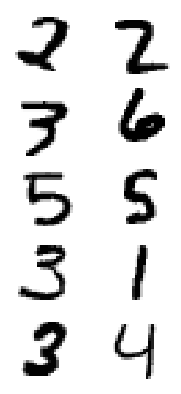

In [59]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [60]:
y_batch

array([[1],
       [0],
       [1],
       [0],
       [0]])

c.在这个训练集上训练DNN。对每一个图片对，你都可以同时将第一张图片传给DNN A，第二张图片传给DNN B。整个网络慢慢就可以分辨出两张图片是否属于同一种类型。

In [61]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [63]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./models/my_digit_comparison_model.ckpt")

0 Train loss: 0.69048864
0 Test accuracy: 0.5061
1 Train loss: 0.6667586
2 Train loss: 0.54621285
3 Train loss: 0.5051319
4 Train loss: 0.43973455
5 Train loss: 0.39108807
5 Test accuracy: 0.8115
6 Train loss: 0.3134558
7 Train loss: 0.32826358
8 Train loss: 0.30579954
9 Train loss: 0.2897354
10 Train loss: 0.27892146
10 Test accuracy: 0.8822
11 Train loss: 0.29858002
12 Train loss: 0.2842432
13 Train loss: 0.25327113
14 Train loss: 0.22505374
15 Train loss: 0.22724876
15 Test accuracy: 0.9097
16 Train loss: 0.21990876
17 Train loss: 0.22201169
18 Train loss: 0.17837317
19 Train loss: 0.15718915
20 Train loss: 0.14760444
20 Test accuracy: 0.9367
21 Train loss: 0.17063677
22 Train loss: 0.17549153
23 Train loss: 0.1394681
24 Train loss: 0.12949528
25 Train loss: 0.14707483
25 Test accuracy: 0.9478
26 Train loss: 0.12104422
27 Train loss: 0.08231911
28 Train loss: 0.11367395
29 Train loss: 0.119283594
30 Train loss: 0.12600785
30 Test accuracy: 0.9564
31 Train loss: 0.14141203
32 Train l

d.现在通过重用和冻结DNN的隐藏层，同时在10个神经元上添加一个softmax输出的方法构建一个新的DNN。在分组2上训练这个网络，看看在每一类只有500张图片的情况下能不能获得比较高的性能。

In [64]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [65]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./models/my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./models/my_digit_comparison_model.ckpt
0 Test accuracy: 0.9724
10 Test accuracy: 0.9723
20 Test accuracy: 0.9744
30 Test accuracy: 0.9732
40 Test accuracy: 0.9743
50 Test accuracy: 0.9738
60 Test accuracy: 0.9732
70 Test accuracy: 0.973
80 Test accuracy: 0.9728
90 Test accuracy: 0.9727


In [66]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [67]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./models/my_mnist_model_final.ckpt")

0 Test accuracy: 0.8798
10 Test accuracy: 0.9294
20 Test accuracy: 0.9319
30 Test accuracy: 0.9431
40 Test accuracy: 0.9429
50 Test accuracy: 0.9431
60 Test accuracy: 0.9428
70 Test accuracy: 0.9424
80 Test accuracy: 0.9426
90 Test accuracy: 0.9424
100 Test accuracy: 0.9424
110 Test accuracy: 0.9426
120 Test accuracy: 0.9425
130 Test accuracy: 0.9424
140 Test accuracy: 0.9424
